In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from random import seed
from random import random
import numbers
import sys, string, os
from mpl_toolkits import mplot3d

import lal, lalsimulation
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions
from lalsimulation import SimInspiralTransformPrecessingWvf2PE
from lalsimulation import SimIMRPhenomPCalculateModelParametersFromSourceFrame
from lal import MSUN_SI, G_SI, C_SI

#-pycbc--------
import pycbc
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import highpass_fir, matched_filter
from pycbc.detector import Detector
import pycbc.noise
from pycbc.noise import noise_from_psd

from pycbc.types import FrequencySeries, TimeSeries, zeros, real_same_precision_as
from pycbc import pnutils
from pycbc.pnutils import f_SchwarzISCO as ISCO
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries
from pycbc.filter import match
from pycbc.filter.matchedfilter import overlap_cplx


#---module related to harmonics waveforms---
from harmonics_waveforms import * 
from conversions import *
from plot_fun import *

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
noise_switch = 1
d_eff_inj = 200       # Effective distance

In [3]:
flow = 20
fref = flow

In [4]:
def Tot_mass_to_Comp_mass(M, q):
    m1 = M * q / (1 + q)
    m2 = M * 1. / (1 + q)
    
    return m1, m2

In [5]:
#masses
M_inj = 48.
q_inj = 6.

# spins and orientations            
cp_inj = 0.6
ce_inj = 0.2

In [6]:
m1_inj, m2_inj = Tot_mass_to_Comp_mass(M_inj, q_inj)
print(m1_inj, m2_inj)

41.142857142857146 6.857142857142857


In [7]:
mchirp_inj, eta_inj = pycbc.pnutils.mass1_mass2_to_mchirp_eta(m1_inj, m2_inj)
print(mchirp_inj, eta_inj)

13.614896355561992 0.12244897959183675


In [8]:
rng = np.random.RandomState(0)
chip_inj = cp_inj
chi_eff_inj = ce_inj
phi0 = rng.random()
theta_JN = rng.random()
phi_JL = rng.random()
print(phi0, theta_JN, phi_JL)

0.5488135039273248 0.7151893663724195 0.6027633760716439


In [9]:
chi1 = np.sqrt(chip_inj**2 + chi_eff_inj**2)
theta1 = np.arctan2(chip_inj, chi_eff_inj)
print(chi1, theta1)

0.6324555320336759 1.2490457723982544


In [10]:
inc_inj, s1x_inj, s1y_inj, s1z_inj, s2x_inj, s2y_inj, s2z_inj = \
        SimInspiralTransformPrecessingNewInitialConditions(theta_JN, phi_JL,
                theta1, 0., # spin orientations
                0., # angle between spins
                chi1, 0.,# spin magnitudes
                m1_inj*MSUN_SI, m2_inj*MSUN_SI, flow, phi0)

In [11]:
print(s1x_inj, s1y_inj, s1z_inj)
print(s2x_inj, s2y_inj, s2z_inj)
print(np.sqrt(s1x_inj**2 + s1y_inj**2 + s1z_inj**2), np.sqrt(s2x_inj**2 + s2y_inj**2 + s2z_inj**2))

-0.4515609338578665 0.39508571603313075 0.2
0.0 0.0 0.0
0.632455532033676 0.0


In [12]:
def chi_prec(mass1, mass2, spin1x, spin1y, spin2x, spin2y):
    """Return chi_p given samples for mass1, mass2, spin1x, spin1y, spin2x,
    spin2y
    """
    mass_ratio = mass2 / mass1
    S1_perp = ((spin1x)**2 + (spin1y)**2)**0.5
    S2_perp = ((spin2x)**2 + (spin2y)**2)**0.5
    chi_p = np.maximum(
        S1_perp, (4 * mass_ratio + 3) / (3 * mass_ratio + 4) * mass_ratio
        * S2_perp
    )
    return chi_p

In [13]:
def chi_effective(mass1, mass2, spin1z, spin2z):
    """Return chi_eff given samples for mass1, mass2, spin1z, spin2z
    """
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

In [14]:
chip_i = chi_prec(m1_inj, m2_inj, s1x_inj, s1y_inj, s2x_inj, s2y_inj)
print(chip_inj, chip_i)

0.6 0.6000000000000001


In [15]:
chi_eff_i = chi_effective(m1_inj, m2_inj, s1z_inj, s2z_inj)
print(chi_eff_inj, chi_eff_i)

0.2 0.17142857142857146


In [16]:
apx = 'IMRPhenomPv2'
fhigh = 2048.
fSamp = 2*fhigh
dt = 1.0/fSamp

In [17]:
sp, sc = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                                    spin1x = s1x_inj, spin1y = s1y_inj, spin1z = s1z_inj, 
                                    spin2x = s2x_inj, spin2y = s2y_inj, spin2z = s2z_inj, 
                                    inclination = inc_inj, coa_phase = phi0, distance = d_eff_inj,
                                    f_lower = flow, f_final = fhigh, delta_t = dt)

In [18]:
print(len(sp), len(sc))

32768 32768


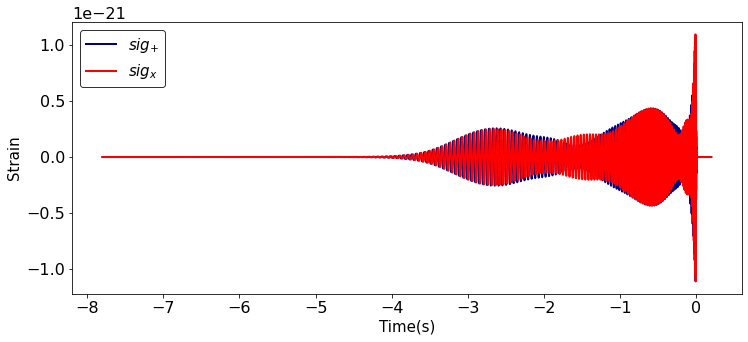

In [19]:
plt.figure(figsize = (12, 5))
plt.plot(sp.sample_times, sp.data, 'navy', label = r'$sig_{+}$')
plt.plot(sc.sample_times, sc.data, 'red', label = r'$sig_{x}$')
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [20]:
T = int(len(sp)/fSamp)
print(T)
ta = int(T/2) + 1.5
print (ta)

8
5.5


In [21]:
N = int(T*fSamp)
N_ta = int(ta*fSamp)
print(N, N_ta)

32768 22528


In [22]:
t = np.linspace(0, T, N)
f = np.linspace(0,int(fSamp/2), int(N/2)+1)
df = 1.0/T
print(df)

0.125


In [23]:
ra = 1.375
dec = -1.2108
psi_J = np.pi/3
t_gps = 0.
detector = 'H1'
det = Detector(detector)
fp, fc = det.antenna_pattern(ra, dec, psi_J, t_gps)
print(fp, fc)

0.2232456941190503 -0.7035253548675515


In [24]:
s = TimeSeries(zeros(len(sp)), delta_t = sp.delta_t)
s.data = fp*sp.data + fc*sc.data

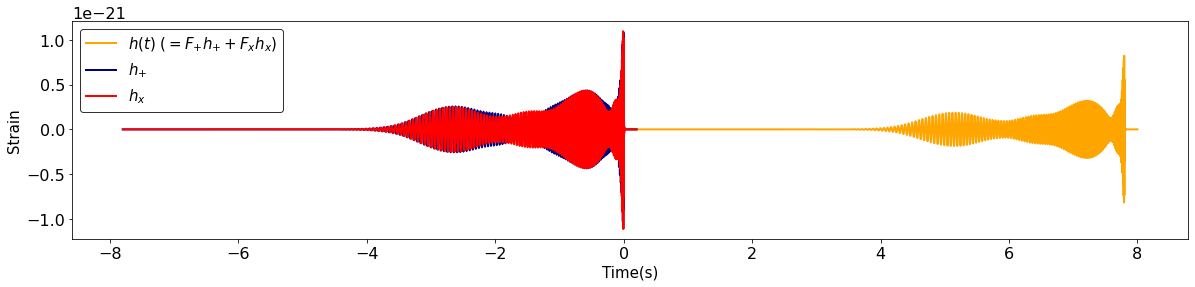

In [25]:
plt.figure(figsize = (20, 4))
plt.plot(s.sample_times, s.data, 'orange', label = r'$h(t) \ ( = F_{+}h_{+} + F_{x}h_{x})$')
plt.plot(sp.sample_times, sp.data, 'navy', label = r'$h_{+}$')
plt.plot(sc.sample_times, sc.data, 'red', label = r'$h_{x}$')
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [26]:
signal = np.roll(s.data, N_ta)
signal = TimeSeries(signal, delta_t = dt)

In [27]:
##PSD
psd = aLIGOZeroDetHighPower(int(N/2) + 1, df, flow)  

#Generate colored Gaussian noise
nt = pycbc.noise.noise_from_psd(N, dt, psd, seed = 127)

In [28]:
print (2*len(psd))
print (N, len(signal))

32770
32768 32768


In [29]:
data = TimeSeries(zeros(N, real_same_precision_as(nt)), dt)
data.data = noise_switch*nt.data + signal.data

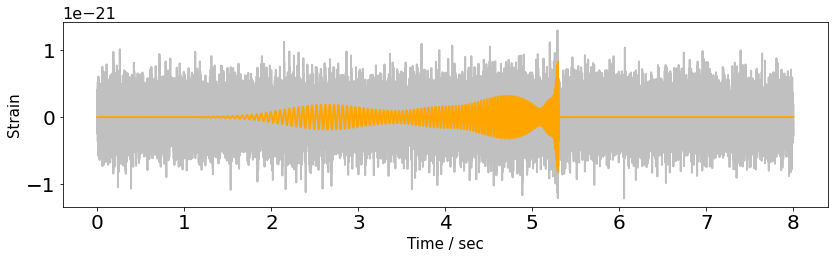

In [30]:
plt.figure(figsize = (12, 4))
plt.plot(data.sample_times, data.data,'silver')
plt.plot(signal.sample_times, signal.data, 'orange')
plt.xlabel('Time / sec', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.tick_params(labelsize = 20, bottom = True, labelbottom = True)
plt.grid(False)
plt.tight_layout()
plt.show()

In [31]:
snr_p = matched_filter(sp, data, psd = psd, low_frequency_cutoff = flow)

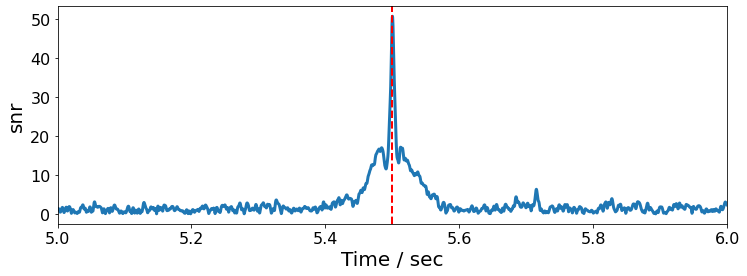

In [32]:
a1 = .5
b1 = .5
plt.figure(figsize = (12, 4))
plt.plot(t, abs(snr_p), '-', lw = 3)
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.show()

In [33]:
hpt_a, hct_a = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, spin1z = s1z_inj, spin2z = s2z_inj, 
                                    inclination = inc_inj, coa_phase = phi0, distance = d_eff_inj,
                                    f_lower = flow, f_final = fhigh, delta_t = dt)

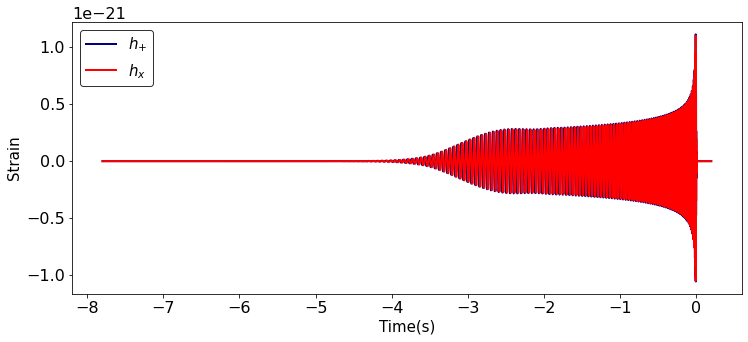

In [34]:
plt.figure(figsize = (12, 5))
plt.plot(hpt_a.sample_times, hpt_a.data, 'navy', label = r'$h_{+}$')
plt.plot(hct_a.sample_times, hct_a.data, 'red', label = r'$h_{x}$')
#plt.xlim(-100, 0)
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.xlabel('Time(s)', fontsize = 15)
plt.ylabel('Strain', fontsize = 15)
plt.show()

In [35]:
snr_a1 = matched_filter(hpt_a, data, psd = psd, low_frequency_cutoff = flow)

<Figure size 864x288 with 0 Axes>

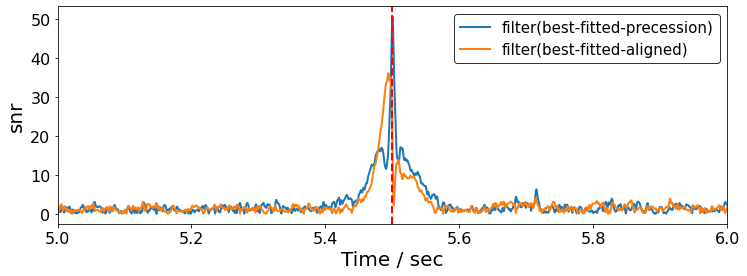

In [36]:
plt.figure(figsize = (12, 4))
a1 = 0.5
b1 = 0.5
j = 9
plt.figure(figsize = (12, 4))
plt.plot(t, abs(snr_p), lw = 2, label = 'filter(best-fitted-precession)')
plt.plot(t, abs(snr_a1), lw = 2, label = 'filter(best-fitted-aligned)')
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [37]:
hpf_a, hcf_a = get_fd_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, spin1z = s1z_inj, spin2z = s2z_inj, 
                              inclination = inc_inj, coa_phase = phi0, distance = 1.,
                              f_lower = flow, f_final = fhigh, delta_f = df)

In [38]:
snr_a2 = matched_filter(hpf_a, data, psd = psd, low_frequency_cutoff = flow)

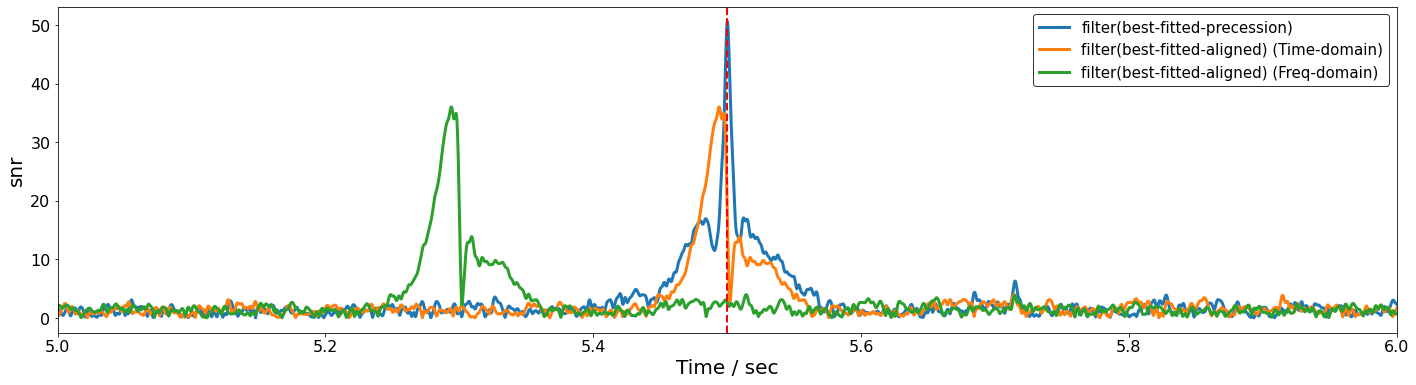

In [39]:
plt.figure(figsize = (24, 6))
a1 = 0.5
b1 = 0.5
j = 9

plt.plot(t, abs(snr_p), lw = 3, label = 'filter(best-fitted-precession)')
plt.plot(t, abs(snr_a1), lw = 3, label = 'filter(best-fitted-aligned) (Time-domain)')
plt.plot(t, abs(snr_a2), lw = 3, label = 'filter(best-fitted-aligned) (Freq-domain)')
plt.axvline(x = ta, linestyle = '--', color = 'r', lw = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [40]:
flen = int(fhigh / df) + 1
print(flen)

16385


In [41]:
chi_inj = np.sqrt(cp_inj**2 + ce_inj**2)
theta_inj = np.arctan2(cp_inj, ce_inj)
a_1 = chi_inj
a_2 = 0.
tilt_1 = theta_inj
tilt_2 = 0.
phi_12 = 0.

In [42]:
fref = flow
beta = calculate_opening_angle(m1_inj, m2_inj, ce_inj, cp_inj, fref)

In [43]:
harm = [0, 1, 2, 3, 4]

In [44]:
harmonics = calculate_precessing_harmonics(m1_inj, m2_inj, a_1, a_2, tilt_1, tilt_2, phi_12, beta, 
                                                d_eff_inj, harm, apx, fref, flow, fhigh, df, flen)

In [45]:
harm0 = harmonics[0]
harm1 = harmonics[1]
harm2 = harmonics[2]
harm3 = harmonics[3]
harm4 = harmonics[4]

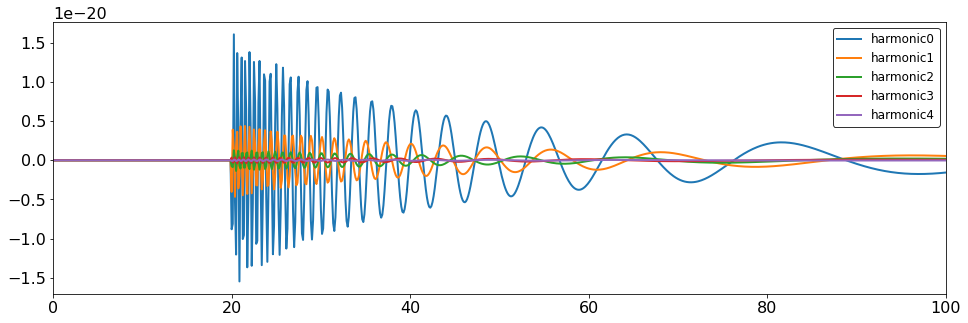

In [46]:
plt.figure(figsize = (16, 5))
plt.plot(harm0.sample_frequencies, np.real(harm0.data), label = 'harmonic0')
plt.plot(harm1.sample_frequencies, np.real(harm1.data), label = 'harmonic1')
plt.plot(harm2.sample_frequencies, np.real(harm2.data), label = 'harmonic2')
plt.plot(harm3.sample_frequencies, np.real(harm3.data), label = 'harmonic3')
plt.plot(harm4.sample_frequencies, np.real(harm4.data), label = 'harmonic4')
plt.xlim(0, 100)
plt.legend(loc = 'best', edgecolor = 'k', fontsize = 12)
plt.show()

In [47]:
snrf_harm0 = matched_filter(harm0, data, psd = psd, low_frequency_cutoff = flow)

In [48]:
snrf_harm1 = matched_filter(harm1, data, psd = psd, low_frequency_cutoff = flow)

In [49]:
snrf_harm2 = matched_filter(harm2, data, psd = psd, low_frequency_cutoff = flow)

In [50]:
snrf_harm3 = matched_filter(harm3, data, psd = psd, low_frequency_cutoff = flow)

In [51]:
snrf_harm4 = matched_filter(harm4, data, psd = psd, low_frequency_cutoff = flow)

In [52]:
snrf_Twoharm = np.sqrt(abs(snrf_harm0)**2 + abs(snrf_harm1)**2)

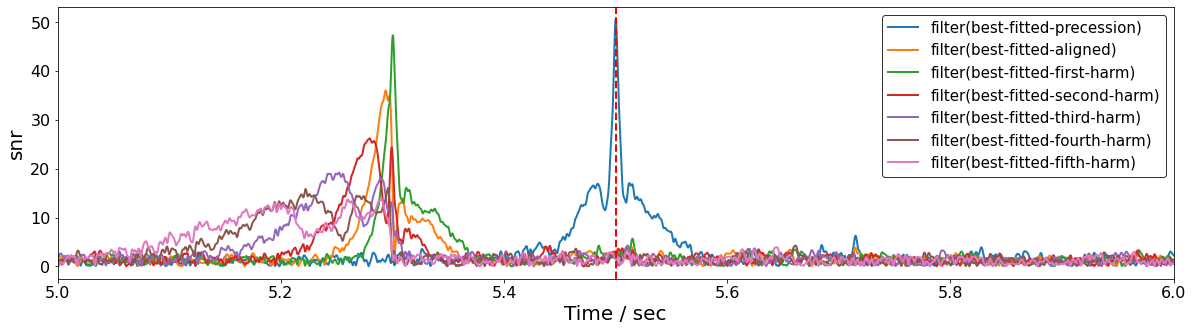

In [53]:
a1 = 0.5
b1 = 0.5
j = 9
plt.figure(figsize = (20, 5))
plt.plot(t, abs(snr_p), label = 'filter(best-fitted-precession)', linewidth = 2)
plt.plot(t, abs(snr_a2), label = 'filter(best-fitted-aligned)', linewidth = 2)
plt.plot(t, abs(snrf_harm0), label = 'filter(best-fitted-first-harm)', linewidth = 2)
plt.plot(t, abs(snrf_harm1), label = 'filter(best-fitted-second-harm)', linewidth = 2)
plt.plot(t, abs(snrf_harm2), label = 'filter(best-fitted-third-harm)', linewidth = 2)
plt.plot(t, abs(snrf_harm3), label = 'filter(best-fitted-fourth-harm)', linewidth = 2)
plt.plot(t, abs(snrf_harm4), label = 'filter(best-fitted-fifth-harm)', linewidth = 2)

#plt.plot(t, snrf_Twoharm, label = 'filter(best-fitted-Two-Harm)', linewidth = 2)
plt.axvline(x = ta, linestyle = '--', lw = 2, color = 'red')
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [55]:
print(max(snrf_Twoharm), max(abs(snr_p)))

52.368437849740815 50.62569943764027


In [56]:
def spin_components(ce_0, cp_0, theta_JN, phi_JL, phi_0, mass1, mass2):
    
    chi1 = np.sqrt(cp_0**2 + ce_0**2)
    theta1 = np.arctan2(cp_0, ce_0)
    a_1 = chi1
    a_2 = 0.
    tilt_1 = theta1
    tilt_2 = 0.
    phi_12 = 0.
    fref = flow
    
    inc, s1x, s1y, s1z, s2x, s2y, s2z = SimInspiralTransformPrecessingNewInitialConditions(theta_JN, phi_JL, \
                                                                                       tilt_1, tilt_2, phi_12, \
                                                                                       a_1, a_2, \
                                                                                       mass1*MSUN_SI, mass2*MSUN_SI,
                                                                                       flow, phi_0)
    
    return inc, s1x, s1y, s1z, s2x, s2y, s2z

In [57]:
theta_JN0 = 0.
phi_JL0 = 0.
phi_00 = 0.

In [58]:
inc0, s1x0, s1y0, s1z0, s2x0, s2y0, s2z0 = spin_components(chi_eff_inj, chip_inj, 
                                                           theta_JN0, phi_JL0,
                                                           phi_00, m1_inj, m2_inj)

In [59]:
theta_JN1 = 0.
phi_JL1 = 0.
phi_01 = np.pi/4

In [60]:
inc1, s1x1, s1y1, s1z1, s2x1, s2y1, s2z1 = spin_components(chi_eff_inj, chip_inj, 
                                                           theta_JN1, phi_JL1,
                                                           phi_01, m1_inj, m2_inj)

In [61]:
theta_JN2 = np.pi/2
phi_JL2 = 0.
phi_02 = np.pi/4

In [62]:
inc2, s1x2, s1y2, s1z2, s2x2, s2y2, s2z2 = spin_components(chi_eff_inj, chip_inj, 
                                                           theta_JN2, phi_JL2,
                                                           phi_02, m1_inj, m2_inj)

In [63]:
theta_JN3 = np.pi/2
phi_JL3 = np.pi/2
phi_03 = 0.

In [64]:
inc3, s1x3, s1y3, s1z3, s2x3, s2y3, s2z3 = spin_components(chi_eff_inj, chip_inj, 
                                                           theta_JN3, phi_JL3,
                                                           phi_03, m1_inj, m2_inj)

In [65]:
print(inc0, inc1, inc2, inc3, inc_inj)

0.5679672480599667 0.5679672480599667 1.5707963267948966 1.0028290787349299 0.5800862853252514


In [66]:
print(s1x0, s1x1, s1x2, s1x3, s1x_inj)
print(s1y0, s1y1, s1y2, s1y3, s1y_inj)
print(s1z0, s1z1, s1z2, s1z3, s1z_inj)

-3.6739403974420595e-17 0.42426406871192845 -0.4242640687119285 1.202772060366429e-17 -0.4515609338578665
0.6 0.4242640687119285 0.42426406871192845 -0.6 0.39508571603313075
0.20000000000000004 0.20000000000000004 0.20000000000000004 0.20000000000000004 0.2


In [67]:
print(s2x0, s2x1, s2x2, s2x3, s2x_inj)
print(s2y0, s2y1, s2y2, s2y3, s2y_inj)
print(s2z0, s2z1, s2z2, s2z3, s2z_inj)

0.0 0.0 0.0 -0.0 0.0
0.0 -0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0


In [68]:
hpt0, hct0 = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                             spin1x = s1x0, spin1y = s1y0, spin1z = s1z0,
                             spin2x = s2x0, spin2y = s2y0, spin2z = s2z0, 
                             inclination = inc0, coa_phase = phi_00, distance = 1.,
                             f_lower = flow, f_final = fhigh, delta_t = 1/fSamp)

In [69]:
len(hpt0)

32768

In [70]:
hpt1, hct1 = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                             spin1x = s1x1, spin1y = s1y1, spin1z = s1z1,
                             spin2x = s2x1, spin2y = s2y1, spin2z = s2z1, 
                             inclination = inc1, coa_phase = phi_01, distance = 1.,
                             f_lower = flow, f_final = fhigh, delta_t = 1/fSamp)

In [71]:
hpt2, hct2 = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                             spin1x = s1x2, spin1y = s1y2, spin1z = s1z2,
                             spin2x = s2x2, spin2y = s2y2, spin2z = s2z2, 
                             inclination = inc2, coa_phase = phi_02, distance = 1., 
                             f_lower = flow, f_final = fhigh, delta_t = 1/fSamp)

In [72]:
hpt3, hct3 = get_td_waveform(approximant = apx, mass1 = m1_inj, mass2 = m2_inj, 
                             spin1x = s1x3, spin1y = s1y3, spin1z = s1z3,
                             spin2x = s2x3, spin2y = s2y3, spin2z = s2z3, 
                             inclination = inc3, coa_phase = phi_03, distance = 1.,
                             f_lower = flow, f_final = fhigh, delta_t = 1/fSamp)

In [73]:
print(len(sp), len(hpt0), len(hpt1), len(hpt2), len(hpt3))

32768 32768 32768 32768 32768


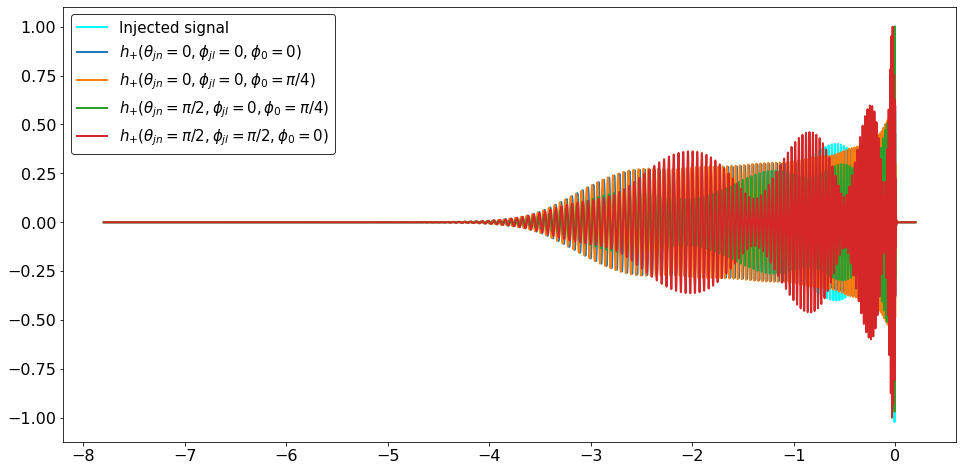

In [74]:
plt.figure(figsize = (16, 8))
plt.plot(sp.sample_times, sp.data/max(sp.data), 'cyan', label = 'Injected signal')
plt.plot(hpt0.sample_times, hpt0.data/max(hpt0.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = 0)$')
plt.plot(hpt1.sample_times, hpt1.data/max(hpt1.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
plt.plot(hpt2.sample_times, hpt2.data/max(hpt2.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
plt.plot(hpt3.sample_times, hpt3.data/max(hpt3.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = \pi/2, \phi_{0} = 0)$')
plt.legend(loc = 'best', edgecolor = 'k', fontsize = 15)
plt.show()

In [75]:
hpt0.resize(len(sp))
hpt1.resize(len(sp))
hpt2.resize(len(sp))
hpt3.resize(len(sp))

In [76]:
print(len(sp), len(hpt0), len(hpt1), len(hpt2), len(hpt3))

32768 32768 32768 32768 32768


In [77]:
snr0 = matched_filter(hpt0, data, psd = psd, low_frequency_cutoff = flow)
snr1 = matched_filter(hpt1, data, psd = psd, low_frequency_cutoff = flow)
snr2 = matched_filter(hpt2, data, psd = psd, low_frequency_cutoff = flow)
snr3 = matched_filter(hpt3, data, psd = psd, low_frequency_cutoff = flow)

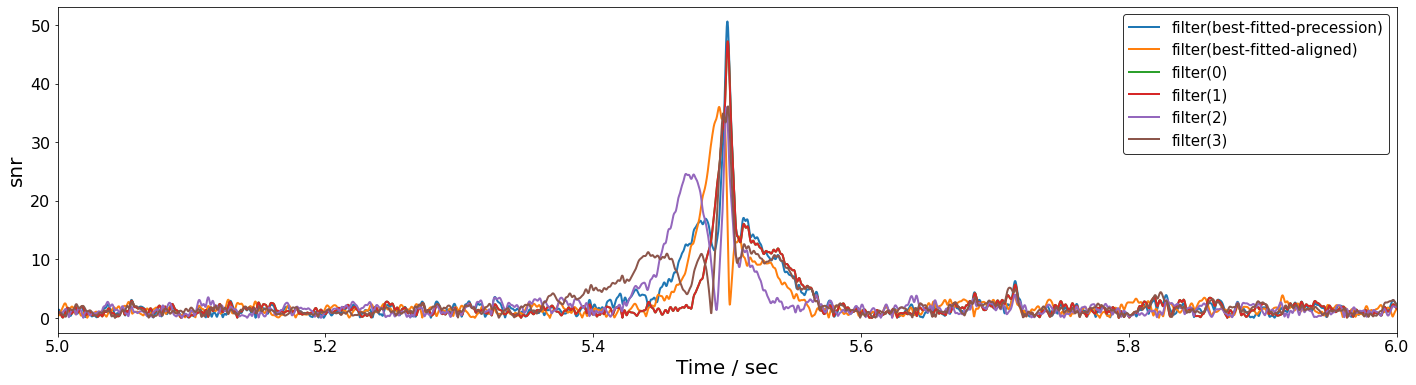

In [78]:
a1 = 0.5
b1 = 0.5
j = 9
plt.figure(figsize = (24, 6))
plt.plot(t, abs(snr_p), label = 'filter(best-fitted-precession)', linewidth = 2)
plt.plot(t, abs(snr_a1), label = 'filter(best-fitted-aligned)', linewidth = 2)
#plt.plot(t, abs(snrf_harm0), label = 'filter(best-fitted-first-harm)', linewidth = 2)
#plt.plot(t, abs(snrf_harm1), label = 'filter(best-fitted-second-harm)', linewidth = 2)
#plt.plot(t, snrf_Twoharm, label = 'filter(best-fitted-Two-Harm)', linewidth = 2)
plt.plot(t, abs(snr0), label = 'filter(0)', linewidth = 2)
plt.plot(t, abs(snr1), label = 'filter(1)', linewidth = 2)
plt.plot(t, abs(snr2), label = 'filter(2)', linewidth = 2)
plt.plot(t, abs(snr3), label = 'filter(3)', linewidth = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [79]:
harm0td = (hpt0 - hpt1)/2

In [80]:
harm1td = -(hpt3 + hpt2)/4

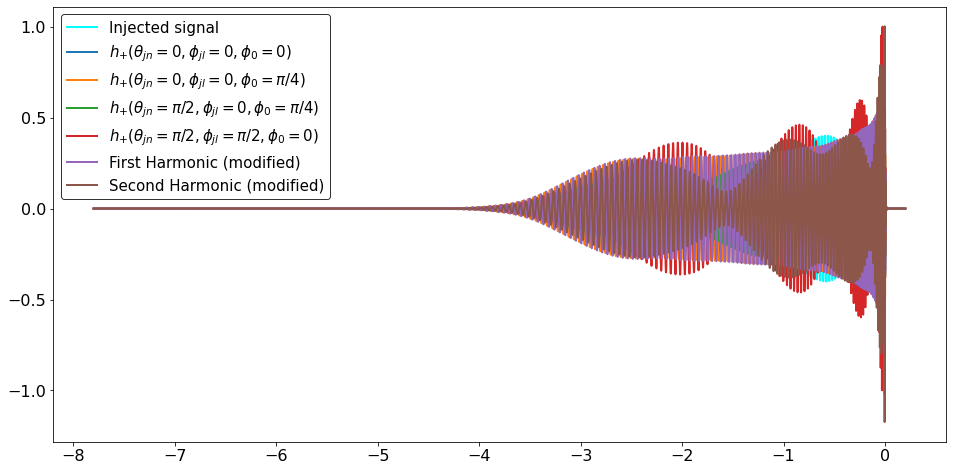

In [91]:
plt.figure(figsize = (16, 8))
plt.plot(sp.sample_times, sp.data/max(sp.data), 'cyan', label = 'Injected signal')
plt.plot(hpt0.sample_times, hpt0.data/max(hpt0.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = 0)$')
plt.plot(hpt1.sample_times, hpt1.data/max(hpt1.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
plt.plot(hpt2.sample_times, hpt2.data/max(hpt2.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
plt.plot(hpt3.sample_times, hpt3.data/max(hpt3.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = \pi/2, \phi_{0} = 0)$')
plt.plot(harm0td.sample_times, harm0td.data/max(harm0td.data), label = 'First Harmonic (modified)')
plt.plot(harm1td.sample_times, harm1td.data/max(harm1td.data), label = 'Second Harmonic (modified)')
plt.legend(loc = 'best', edgecolor = 'k', fontsize = 15)
plt.show()

In [82]:
snr_h0 = matched_filter(harm0td, data, psd = psd, low_frequency_cutoff = flow)
snr_h1 = matched_filter(harm1td, data, psd = psd, low_frequency_cutoff = flow)

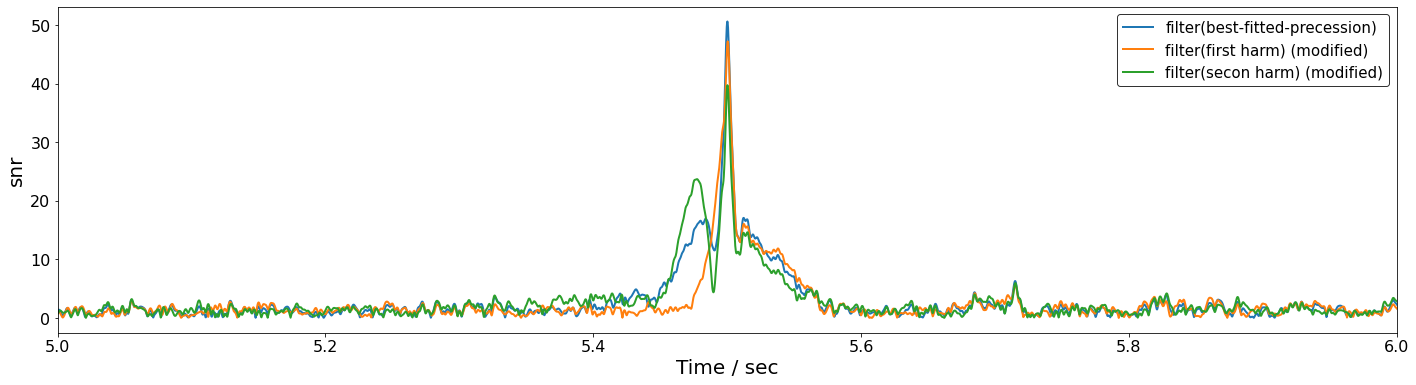

In [83]:
a1 = 0.5
b1 = 0.5
j = 9
plt.figure(figsize = (24, 6))
plt.plot(t, abs(snr_p), label = 'filter(best-fitted-precession)', linewidth = 2)
#plt.plot(t, abs(snr_f0a), label = 'filter(best-fitted-aligned)', linewidth = 2)
#plt.plot(t, abs(snrf_harm0), label = 'filter(best-fitted-first-harm)', linewidth = 2)
#plt.plot(t, abs(snrf_harm1), label = 'filter(best-fitted-second-harm)', linewidth = 2)
#plt.plot(t, snrf_Twoharm, label = 'filter(best-fitted-Two-Harm)', linewidth = 2)
#plt.plot(t, abs(snr0), label = 'filter(0)', linewidth = 2)
#plt.plot(t, abs(snr1), label = 'filter(1)', linewidth = 2)
#plt.plot(t, abs(snr2), label = 'filter(2)', linewidth = 2)
#plt.plot(t, abs(snr3), label = 'filter(3)', linewidth = 2)
plt.plot(t, abs(snr_h0), label = 'filter(first harm) (modified)', linewidth = 2)
plt.plot(t, abs(snr_h1), label = 'filter(secon harm) (modified)', linewidth = 2)
plt.xlabel('Time / sec')
plt.ylabel('snr')
plt.xlim([ta - a1, ta + b1])
plt.legend(loc = 'best', edgecolor = 'black', fontsize = 15)
plt.show()

In [84]:
chi_p0 = chi_prec(m1_inj, m2_inj, s1x0, s1y0, s2x0, s2y0)
chi_eff0 = chi_effective(m1_inj, m2_inj, s1z0, s2z0)

chi_p1 = chi_prec(m1_inj, m2_inj, s1x1, s1y1, s2x1, s2y1)
chi_eff1 = chi_effective(m1_inj, m2_inj, s1z1, s2z1)

chi_p2 = chi_prec(m1_inj, m2_inj, s1x2, s1y2, s2x2, s2y2)
chi_eff2 = chi_effective(m1_inj, m2_inj, s1z2, s2z2)

chi_p3 = chi_prec(m1_inj, m2_inj, s1x3, s1y3, s2x3, s2y3)
chi_eff3 = chi_effective(m1_inj, m2_inj, s1z3, s2z3)

print(chi_p0, chi_p1, chi_p2, chi_p3, chip_inj)
print(chi_eff0, chi_eff1, chi_eff2, chi_eff3, chi_eff_inj)

0.6 0.6 0.6 0.6 0.6
0.17142857142857149 0.17142857142857149 0.17142857142857149 0.17142857142857149 0.2


In [85]:
harm0_td0 = harm0.to_timeseries()
harm1_td1 = harm1.to_timeseries()

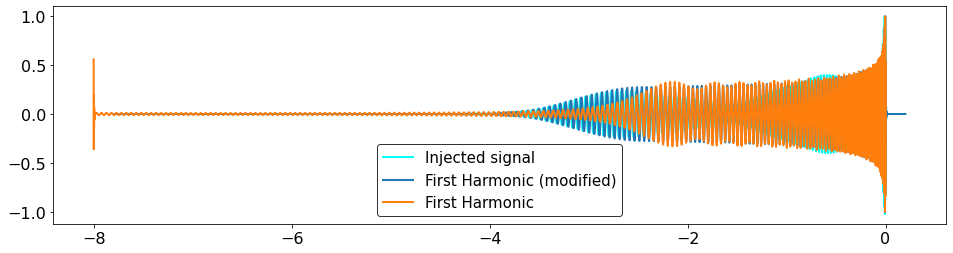

In [89]:
plt.figure(figsize = (16, 4))
plt.plot(sp.sample_times, sp.data/max(sp.data), 'cyan', label = 'Injected signal')
# plt.plot(hpt0.sample_times, hpt0.data/max(hpt0.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = 0)$')
# plt.plot(hpt1.sample_times, hpt1.data/max(hpt1.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
# plt.plot(hpt2.sample_times, hpt2.data/max(hpt2.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
# plt.plot(hpt3.sample_times, hpt3.data/max(hpt3.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = \pi/2, \phi_{0} = 0)$')
plt.plot(harm0td.sample_times, harm0td.data/max(harm0td.data), label = 'First Harmonic (modified)')
#plt.plot(harm1td.sample_times, harm1td.data/max(harm1td.data), label = 'Second Harmonic')
plt.plot(harm0_td0.sample_times, harm0_td0.data/max(harm0_td0.data), label = 'First Harmonic')
#plt.plot(harm1_td1.sample_times, harm1_td1.data/max(harm1_td1.data), label = 'Second Harmonic')

plt.legend(loc = 'best', edgecolor = 'k', fontsize = 15)
plt.show()

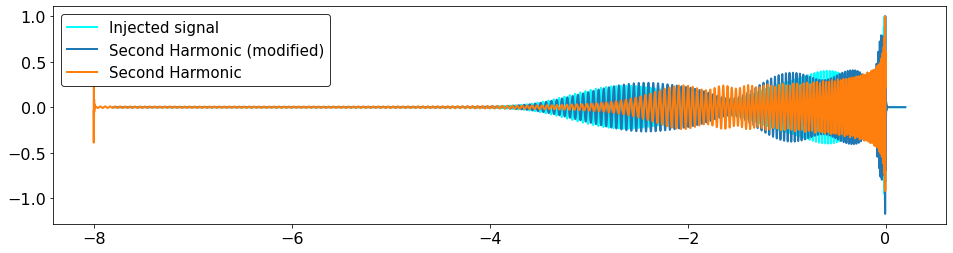

In [88]:
plt.figure(figsize = (16, 4))
plt.plot(sp.sample_times, sp.data/max(sp.data), 'cyan', label = 'Injected signal')
# plt.plot(hpt0.sample_times, hpt0.data/max(hpt0.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = 0)$')
# plt.plot(hpt1.sample_times, hpt1.data/max(hpt1.data), label = r'$h_{+}(\theta_{jn} = 0, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
# plt.plot(hpt2.sample_times, hpt2.data/max(hpt2.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = 0, \phi_{0} = \pi/4)$')
# plt.plot(hpt3.sample_times, hpt3.data/max(hpt3.data), label = r'$h_{+}(\theta_{jn} = \pi/2, \phi_{jl} = \pi/2, \phi_{0} = 0)$')
#plt.plot(harm0td.sample_times, harm0td.data/max(harm0td.data), label = 'First Harmonic')
plt.plot(harm1td.sample_times, harm1td.data/max(harm1td.data), label = 'Second Harmonic (modified)')
#plt.plot(harm0_td0.sample_times, harm0_td0.data/max(harm0_td0.data), label = 'First Harmonic')
plt.plot(harm1_td1.sample_times, harm1_td1.data/max(harm1_td1.data), label = 'Second Harmonic')

plt.legend(loc = 'best', edgecolor = 'k', fontsize = 15)
plt.show()